# Malleco data
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr>

In [46]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

import sys
sys.path.append('/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/src')

from src.utils import *
from src.kernels import Kernel

from scipy.stats import wasserstein_distance

init_notebook_mode(connected=True) ## plotly init
seed = 123
random.seed = seed

import os
path_data = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/data/"

In [47]:
malleco = pd.read_csv(path_data + 'malleco.csv')

In [48]:
malleco.head(), malleco.columns

(   Year Value
 0  1242 1.343
 1  1243 1.044
 2  1244 1.174
 3  1245 1.068
 4  1246 0.913,
 Index(['Year Value'], dtype='object'))

In [49]:
years = []
values = []
for i in range(malleco.shape[0]):
    years.append(malleco['Year Value'][i][:4])
    values.append(malleco['Year Value'][i][5:])
    
df_malleco = pd.DataFrame({'Year': years, 'Value': values})

In [50]:
df_malleco.head()

,Year,Value
0,1242,1.343
1,1243,1.044
2,1244,1.174
3,1245,1.068
4,1246,0.913


In [51]:
df_malleco['Value'] = pd.to_numeric(df_malleco['Value'])
df_malleco['Year'] = pd.to_numeric(df_malleco['Year'])

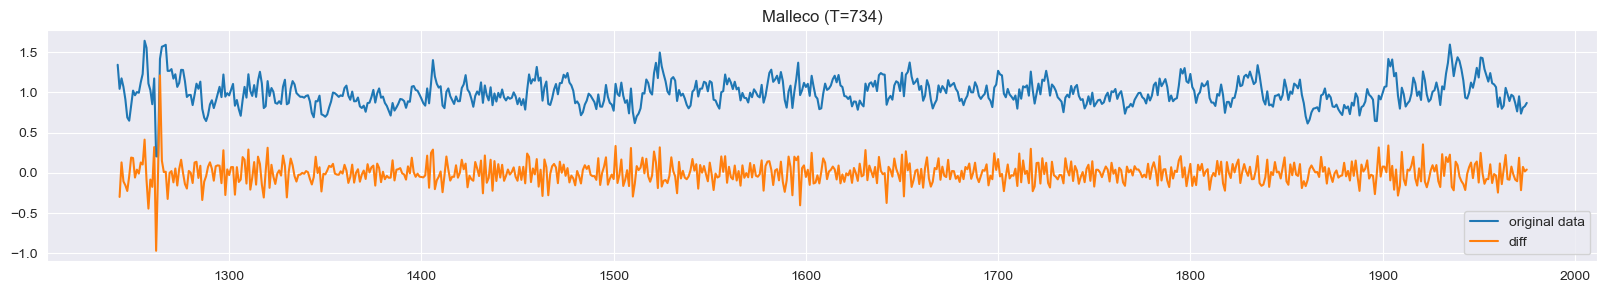

In [52]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df_malleco['Year'], df_malleco['Value'], label="original data")
plt.plot(df_malleco['Year'], df_malleco['Value'].diff(), label="diff")
plt.legend()
plt.title("Malleco (T=734)")
plt.show()

In [53]:
df_malleco.shape

(734, 2)

In [54]:
# import pyreadr
# result = pyreadr.read_r(path_data + 'malleco.rda') # also works for Rds, rda
# print(result.keys()) 

In [55]:
df_malleco['Value'].values.reshape(-1, 1).shape

(734, 1)

In [56]:
df_malleco['Value'].values

array([1.343, 1.044, 1.174, 1.068, 0.913, 0.688, 0.648, 0.838, 1.022,
       0.964, 1.004, 0.995, 1.124, 1.228, 1.641, 1.554, 1.11 , 1.027,
       0.853, 1.173, 0.205, 0.205, 1.416, 1.567, 1.577, 1.591, 1.267,
       1.267, 1.289, 1.171, 1.225, 1.068, 1.117, 1.28 , 1.278, 1.138,
       0.943, 0.967, 0.968, 0.842, 0.97 , 1.108, 1.045, 1.133, 0.796,
       0.686, 0.644, 0.719, 0.85 , 0.902, 0.805, 0.887, 0.98 , 1.069,
       0.941, 1.222, 0.947, 0.99 , 0.962, 1.033, 1.105, 0.834, 0.905,
       0.792, 0.709, 0.905, 1.068, 0.935, 1.225, 1.017, 0.956, 1.09 ,
       0.944, 1.145, 1.256, 1.111, 0.805, 0.828, 1.14 , 0.954, 1.054,
       1.007, 0.869, 0.859, 0.89 , 0.856, 1.071, 1.157, 0.852, 0.868,
       1.046, 1.14 , 1.1  , 0.992, 0.967, 0.945, 0.945, 0.934, 0.956,
       0.964, 0.888, 0.744, 0.691, 0.891, 0.889, 0.959, 0.728, 0.716,
       0.697, 0.726, 0.813, 0.886, 0.998, 0.989, 0.968, 0.944, 0.963,
       0.954, 1.054, 1.084, 0.959, 0.908, 1.01 , 0.889, 0.891, 0.936,
       0.826, 0.806,

In [63]:
df_malleco['Value'].diff()
values_array = []
for i in range(df_malleco.shape[0]-1):
    values_array.append(df_malleco['Value'][i+1] - df_malleco['Value'][i])

In [66]:
values_array = np.array(values_array)
values_array.size

733

In [57]:
np.where(df_malleco['Value'].diff() == np.nan)

(array([], dtype=int64),)

# Nadara-Watson estimator 

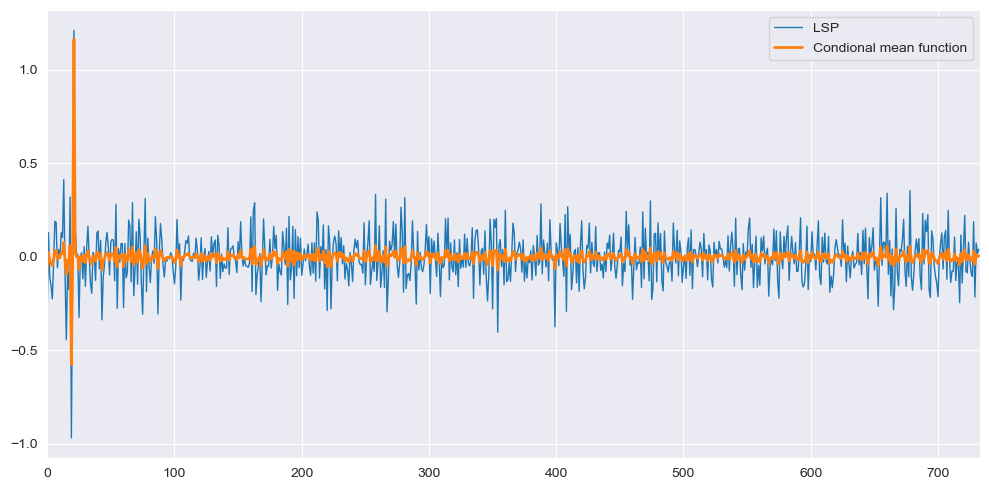

In [75]:
space_kernel = "gaussian" # "silverman"
time_kernel = "uniform"
T = df_malleco.shape[0] -1
d = 1
bandwidth = T **(-0.4 / (d+1)) #/ 10
X_dict = values_array.reshape(-1,1) #df_malleco['Value'].diff().values.reshape(-1, 1)
X_tvar_2 = values_array #df_malleco['Value'].diff().values

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict, t)
    
m_hat= [np.sum(weights[str(t)] * values_array) for t in range(T)]

path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"
plt.rcParams["figure.figsize"] = (10,5)

u_var = np.linspace(0., 1., T)

plt.plot(X_tvar_2, lw=1, label="LSP")
plt.plot(np.array(m_hat), lw=2, label="Condional mean function")
# plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
# plt.plot(X_tvar_2_mean)
# plt.xticks(np.arange(0, T+1, 200, dtype=int))
plt.xlim(0, T)
# plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
plt.legend()
plt.tight_layout()
plt.savefig(path_fig+"locally_process_conditional_mean_Guassina_space_kernel_uniform_tiem_kernel.pdf", dpi=150)

$$
h = C \times \frac{1}{T^{\xi}}
$$

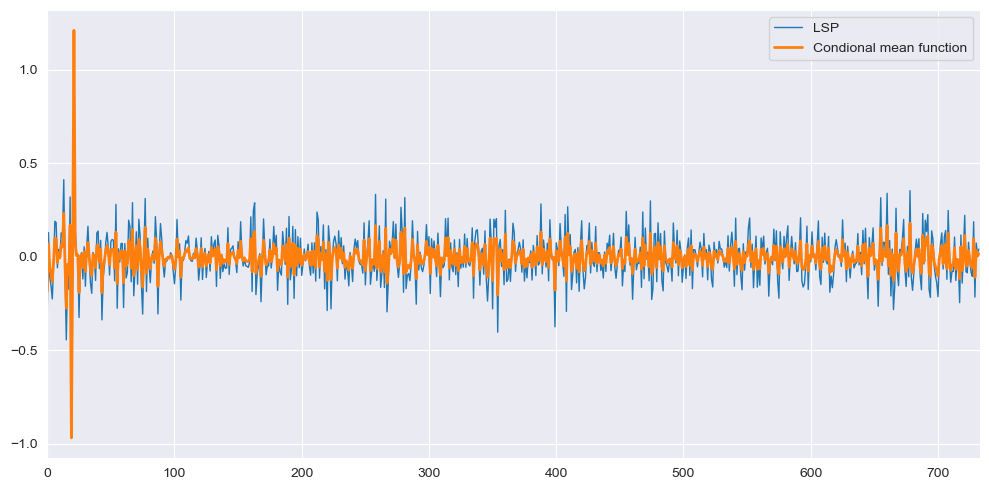

In [76]:
# C = 2
space_kernel = "gaussian" # "silverman"
time_kernel = "uniform"
T = df_malleco.shape[0] -1
d = 1
bandwidth = T **(-0.4 / (d+1)) / 2
X_dict = values_array.reshape(-1,1) #df_malleco['Value'].diff().values.reshape(-1, 1)
X_tvar_2 = values_array #df_malleco['Value'].diff().values

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict, t)
    
m_hat= [np.sum(weights[str(t)] * values_array) for t in range(T)]

path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"
plt.rcParams["figure.figsize"] = (10,5)

u_var = np.linspace(0., 1., T)
plt.plot(X_tvar_2, lw=1, label="LSP")
plt.plot(np.array(m_hat), lw=2, label="Condional mean function")
plt.xlim(0, T)
plt.legend()
plt.tight_layout()
plt.savefig(path_fig+"locally_process_conditional_mean_Guassina_space_kernel_uniform_tiem_kernel.pdf", dpi=150)

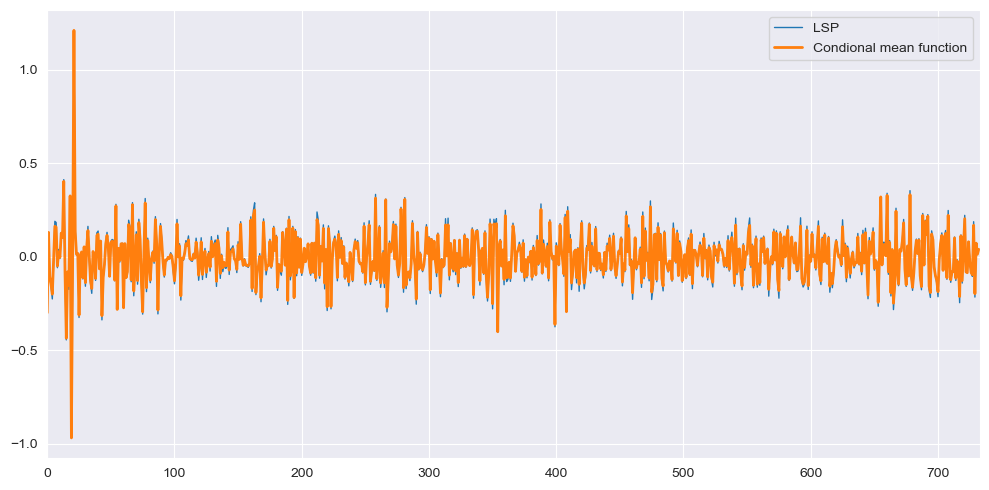

In [77]:
# C = 6
space_kernel = "gaussian" # "silverman"
time_kernel = "uniform"
T = df_malleco.shape[0] -1
d = 1
bandwidth = T **(-0.4 / (d+1)) / 6
X_dict = values_array.reshape(-1,1) #df_malleco['Value'].diff().values.reshape(-1, 1)
X_tvar_2 = values_array #df_malleco['Value'].diff().values

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict, t)
    
m_hat= [np.sum(weights[str(t)] * values_array) for t in range(T)]

path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"
plt.rcParams["figure.figsize"] = (10,5)

u_var = np.linspace(0., 1., T)
plt.plot(X_tvar_2, lw=1, label="LSP")
plt.plot(np.array(m_hat), lw=2, label="Condional mean function")
plt.xlim(0, T)
plt.legend()
plt.tight_layout()
plt.savefig(path_fig+"locally_process_conditional_mean_Guassina_space_kernel_uniform_tiem_kernel.pdf", dpi=150)

# Nadrawatson on the process not on its diff 

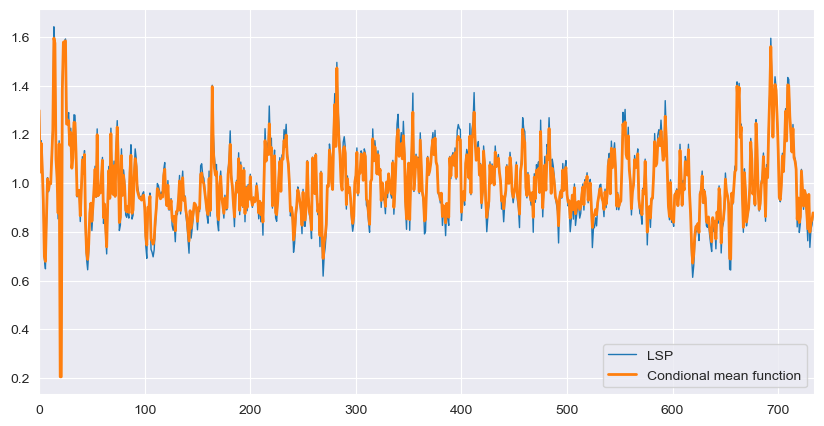

In [80]:
space_kernel = "gaussian" # "silverman"
time_kernel = "uniform"
T = df_malleco.shape[0] 
d = 1
bandwidth = T **(-0.4 / (d+1)) / 4
X_dict = df_malleco['Value'].values.reshape(-1,1) #df_malleco['Value'].diff().values.reshape(-1, 1)
X_tvar_2 = df_malleco['Value'].values #df_malleco['Value'].diff().values

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict, t)
    
m_hat= [np.sum(weights[str(t)] * X_tvar_2) for t in range(T)]

path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"
plt.rcParams["figure.figsize"] = (10,5)

u_var = np.linspace(0., 1., T)
plt.plot(X_tvar_2, lw=1, label="LSP")
plt.plot(np.array(m_hat), lw=2, label="Condional mean function")
plt.xlim(0, T)
plt.legend()